                      "Book – Which grade my text belongs to ?"  
              "Student – is my notes sheet text too easy/tough for my peers?"  

- Readability is a quality of writing. A readability score, tells you how much energy the reader (student) will have to expend to absorb what the writer is saying

- A sentence can be grammatically correct but still hard to absorb for a student, means readability score is high for his grade

- Teachers can provide the readability feedback on the answer sheets which will help to improve a student’s level of writing 

- AI based solution which will help identifying the appropriate well-matched reading/writing level of text

**References :**
- Scott A. Crossley, Stephen Skalicky, Mihai Dascalu, Danielle S. McNamara & Kristopher Kyle (2017): Predicting Text Comprehension, Processing, and Familiarity in Adult Readers: New Approaches to Readability Formulas, Discourse Processes, DOI: http://dx.doi.org/10.1080/0163853X.2017.1296264 
- https://jamesmccaffrey.wordpress.com/2020/01/31/an-intuitive-explanation-of-the-bradley-terry-model/
- https://towardsdatascience.com/aggregating-pairwise-comparison-inspired-by-a-demo-at-icml-2021-c6fdc05680e2 
- https://www.grammarly.com/blog/readability-scores/ 
- https://support.microsoft.com/en-us/office/get-your-document-s-readability-and-level-statistics-85b4969e-e80a-4777-8dd3-f7fc3c8b3fd2 

In [1]:
# Weights trained over here
!ls /content/drive/MyDrive/kaggle/ReadabilityScore/roberta-base-ctraining

RoBERTa_Base_v1_v0_fold0.h5  RoBERTa_Base_v1_v0_fold3.h5
RoBERTa_Base_v1_v0_fold1.h5  RoBERTa_Base_v1_v0_fold4.h5
RoBERTa_Base_v1_v0_fold2.h5


In [ ]:
# Dataset (ref: https://www.kaggle.com/c/commonlitreadabilityprize/data)
# https://raw.githubusercontent.com/sachin-rastogi/Projects/master/ReadabilityScore/train.csv
# https://raw.githubusercontent.com/sachin-rastogi/Projects/master/ReadabilityScore/test.csv

In [ ]:
!pip install transformers==3.0.2

In [ ]:
# if you put path here we load model instead of train model
# if you wish to train a model in this notebook use None instead of path
LOAD_MODEL_PATH = '/content/drive/MyDrive/kaggle/ReadabilityScore/roberta-base-ctraining/' #or None #VER 1
#LOAD_MODEL_PATH = None
COMPUTE_OOF = True
PREDICT_TEST = False
VER = 1
VER2 = 0

import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import KFold
from transformers import RobertaTokenizer, TFRobertaModel

import tensorflow as tf
print('TF',tf.__version__)

TF 2.7.0


In [ ]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('mixed precision enabled')

mixed precision enabled


In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/sachin-rastogi/Projects/master/ReadabilityScore/train.csv')
print( train.shape )
train.head()

(2834, 6)


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [ ]:
PREDICT_TEST, COMPUTE_OOF

(False, True)

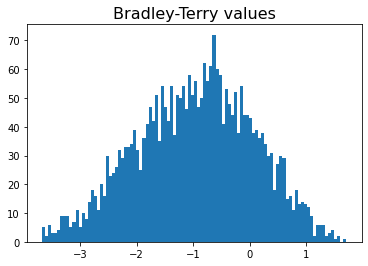

In [ ]:
plt.hist(train.target.values,bins=100)
plt.title('Bradley-Terry values',size=16)
plt.show()

In [ ]:
train.target.values.min(), train.target.values.max()

(-3.676267773, 1.7113898269999999)

In [ ]:
MAX_TOK = 250
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

This DataGeneratot is doing two things
1. Encoding the first excerpt and second excerpt.
2. Second excerpt is choosed Randomply from the batch size samples.
3. Converting Bradley-Terry Target Values into probabilities that first excerpt is more easy than the second excerpt.


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size=32, shuffle=False, tokenizer=tokenizer): 
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.tokenizer = tokenizer
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.df) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        print(f"__getitem__{index}")
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)        
        return X,y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.df ) )
        if self.shuffle: np.random.shuffle(self.indexes)
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        #pdb.set_trace()
        X = np.ones((len(indexes),MAX_TOK*2),dtype='int32')
        y = np.zeros(len(indexes),dtype='float32')
        
        y1 = np.zeros(len(indexes),dtype='float32')
        y2 = np.zeros(len(indexes),dtype='float32')
        
        df = self.df.loc[indexes]
        text = df.excerpt.values
            
        for k in range(len(text)):
            # ENCODE FIRST EXCERPT
            use = text[k]
            tk = self.tokenizer.encode(use)
            ln = min(MAX_TOK,len(tk))
            X[k,:ln] = tk[:MAX_TOK]
            
            # RANDOM PICK AND ENCODE SECOND EXCERPT FOR COMPARISON
            rw = np.random.randint(0,len(self.df))
            #print(f"k-{k} rw-{rw}")
            use = self.df.excerpt.values[rw]
            tk = self.tokenizer.encode(use)
            ln2 = min(MAX_TOK,len(tk))
            X[k,ln] = 2
            X[k,ln+1:ln+ln2] = tk[1:MAX_TOK]
            y2[k] = self.df.target.values[rw]
        y1 = df.target.values
            
        for k in range(len(indexes)):
            # CONVERT BRADLEY-TERRY VALUES INTO PROBABILITIES
            # THAT FIRST EXCERPT IS MORE WASY THAN SECOND EXCERPT
            t = np.exp( y1[k]-y2[k] )
            y[k,] = t/(t+1)
        
        #pdb.set_trace()
        return X,y

### Encoding Examples

In [ ]:
fake_data = pd.DataFrame(columns=['id','excerpt','target'])
fake_data.loc[0] = [1,'This is Sentence one',1]
fake_data.loc[1] = [2,'My Name is Sachin',0]
fake_data.loc[2] = [3,'It is tough Sentence',-1]
fake_data.head()

,id,excerpt,target
0,1,This is Sentence one,1
1,2,My Name is Sachin,0
2,3,It is tough Sentence,-1


In [ ]:
trn = DataGenerator(fake_data)

In [ ]:
for b in trn:
    break

__getitem__0


In [ ]:
b[0][0,:16], b[1][0]

(array([    0,   713,    16, 12169,  4086,    65,     2,     2,   713,
           16, 12169,  4086,    65,     2,     1,     1], dtype=int32), 0.5)

In [ ]:
b[0][1,:16], b[1][1]

(array([    0,  2387, 10704,    16, 19686,   179,     2,     2,  2387,
        10704,    16, 19686,   179,     2,     1,     1], dtype=int32), 0.5)

In [ ]:
tokenizer.encode('This is Sentence one', 'My Name is Sachin')

[0, 713, 16, 12169, 4086, 65, 2, 2, 2387, 10704, 16, 19686, 179, 2]

## Create Model with Classification head  
  Predict the Probability of being First Excerpt easier than the second Excerpt.

In [ ]:
def build_model(use_cls_token=False):
    
    tokens = tf.keras.layers.Input(shape=(MAX_TOK*2,), name = 'tokens', dtype=tf.int32)
    masks = tf.cast( tokens!=1, dtype=tf.int32 )
    
    bert_model = TFRobertaModel.from_pretrained('roberta-base') 
    
    x = bert_model(tokens, attention_mask=masks)  

    # BUILD HEAD WITH EITHER CLS TOKEN OR MEAN LAST LAYER TOKENS
    if use_cls_token:
        x = x[0][:,0,:]
        x = tf.keras.layers.Dense(768,activation='tanh')(x)
    else: #use mean last layer
        x = tf.keras.layers.GlobalAveragePooling1D()(x[0])
        
    x = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=tokens, outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
                  loss = [tf.keras.losses.BinaryCrossentropy()]) 
    
    #model.summary()
    #print("------------------Bert Model Summary---------------------")
    bert_model.summary()
    return model, bert_model

If model is not trained i.e. LOAD_MODEL_PATH is None, train the model now.

In [ ]:
if LOAD_MODEL_PATH is None:
    skf = KFold(n_splits=5, random_state=42, shuffle=True)

    for fold, (idx_t, idx_v) in enumerate(skf.split(train)):
    
        print('#'*25)
        print('### FOLD',fold+1)
        print('#'*25)
    
        model,_ = build_model()
    
        #train_gen = DataGenerator(train.iloc[idx_t], shuffle=True, batch_size=8, augment=False)
        train_gen = DataGenerator(train.iloc[idx_t], shuffle=True, batch_size=8)
        val_gen = DataGenerator(train.iloc[idx_v], batch_size=16)
        
        sv = tf.keras.callbacks.ModelCheckpoint(
            'RoBERTa_Base_v%i_v%i_fold%i.h5'%(VER,VER2,fold), monitor='val_loss', verbose=1, 
            save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch'
        )
        rop = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.3, patience=2, verbose=1,
            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
        )
        
        model.fit(train_gen, validation_data = val_gen,
            epochs=10, verbose=1, callbacks=[sv,rop],
            use_multiprocessing=True, workers=2)

## Inference  
For each test excerpt that we wish to predict, we must compare it with 32 train excerpts. Then we will deduce it's Bradley-Terry value from those 32 comparisons.  
   Each test excerpt will be compared with 16 train excerpt as first encoded string and with remaining 16 train excerpt as second excerpt.

In [ ]:
mn = train.target.mean()
st = train.target.std()
RANGE_LOW = mn-st
RANGE_HIGH = mn+st
COMPARE = 8
COMPARE = 32

In [ ]:
class DataGenerator2(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df1, df2, batch_size=COMPARE, tokenizer=tokenizer, log=[]): 

        self.df1 = df1.reset_index(drop=True)
        self.df2 = df2.reset_index(drop=True)
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.log = log
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.df1)*2

    def __getitem__(self, index):
        'Generate one batch of data'
        X = self.__data_generation(index)    
        return X
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self,index):
        'Generates data containing batch_size samples' 
        
        idx = index//2
        mode = index%2
        X = np.ones((self.batch_size,MAX_TOK*2),dtype='int32')
        
        use1 = self.df1.excerpt.values[idx]
        if mode==0:
            tk = self.tokenizer.encode(use1)
            ln = min(MAX_TOK,len(tk))
            for k in range(self.batch_size):
                
                # FIRST SENTENCE
                X[k,:ln] = tk[:MAX_TOK]
            
                # SECOND SENTENCE
                rw = self.df2.loc[(self.df2.target>RANGE_LOW)&(self.df2.target<RANGE_HIGH)].sample(1).index[0]
                use = self.df2.excerpt.values[rw]
                tk2 = self.tokenizer.encode(use)
                ln2 = min(MAX_TOK,len(tk2))
                X[k,ln] = 2
                X[k,ln+1:ln+ln2] = tk2[1:MAX_TOK]
                
                # RECORD TARGET
                t = self.df2.target.values[rw]
                self.log.append(t)
            
        else:
            tk = self.tokenizer.encode(use1)
            ln2 = min(MAX_TOK,len(tk))
            for k in range(self.batch_size):
                
                # FIRST SENTENCE
                rw = self.df2.loc[(self.df2.target>RANGE_LOW)&(self.df2.target<RANGE_HIGH)].sample(1).index[0]
                use = self.df2.excerpt.values[rw]
                tk2 = self.tokenizer.encode(use)
                ln = min(MAX_TOK,len(tk2))
                X[k,:ln] = tk2[:MAX_TOK]
            
                # SECOND SENTENCE
                X[k,ln] = 2
                X[k,ln+1:ln+ln2] = tk[1:MAX_TOK]
                
                # RECORD TARGET
                t = self.df2.target.values[rw]
                self.log.append(t)
                                  
        return X

In [ ]:
# log = []

# test_gen = DataGenerator2(test.iloc[:], train.iloc[:], log=log)
# #len(test_gen), len(test)

In [ ]:
# for b in test_gen:
#     break
# len(b)

In [ ]:
test_data = pd.DataFrame(columns=['id','grade','excerpt','target'])

# 1
test_data.loc[0] = [1, 1, "houses and buildings. Did you know that animals in nature also live in communities Each kind of animal has a different home. Each kind of animal does something different to live. Some animals eat plants and live in holes in the ground. Some animals eat other animals. Click on the",0]
# 2
test_data.loc[1] = [2, 2, "the wind sing through my branches. Look, Baby, weve got some grown up tree things to discuss. It would just be better if you were asleep, that all. I just won listen. inner, ninner, ninner. I can hear you. Stop itl Baby Pine lower lip begins to",0]
# 4
test_data.loc[2] = [3, 4, "was a symbol of unhappy times. It was a time when many Georgians, including African Americans, were badly treated. They did not want this symbol in their state flag. Georgians argued a long time about changing their flag. For nearly years, Tyrone Brooks, a state representative from Atlanta, had asked  ",0]
# 10
test_data.loc[3] = [4, 10, "a clear and forceful argument. For Number choose the sentence that is complete and written correctly. Another trick makes an enormous elephant seem to disappeared into thin air. Another trick makes an enormous elephant seems to disappear into thin air. October Elmo Pet Emporium Cortez Court Abingdon Virginia, Dear ",0]
# 12
test_data.loc[4] = [5, 12, "occurring phenomenon, manmade by products are rapidly increasing the rate at which greenhouse gases buildup. The combustion of fossil fuels to power factories, for example, has been the major contributor of COAccording to a recent report published by the .. Intergovernmental Panel on Climate Change , the planet is warming",0]


test_data.head()

,id,grade,excerpt,target
0,1,1,houses and buildings. Did you know that animal...,0
1,2,2,"the wind sing through my branches. Look, Baby,...",0
2,3,4,was a symbol of unhappy times. It was a time w...,0
3,4,10,a clear and forceful argument. For Number choo...,0
4,5,12,"occurring phenomenon, manmade by products are ...",0


In [ ]:
log = []
fold = 0

test_gen = DataGenerator2(test_data.iloc[:], train.iloc[:], log=log)

In [ ]:
for b in test_gen:
    break

In [ ]:
len(b), log

(32,
 [-1.400318025,
  -1.676793243,
  -0.878020998,
  -0.69788138,
  -0.8017068759999999,
  -0.296345608,
  -0.522537934,
  -0.672687728,
  -1.506474394,
  -0.78202723,
  -0.31537234199999997,
  -1.554428476,
  -1.545126414,
  -0.609884124,
  0.009684340999999999,
  -0.11369393400000001,
  -0.41655201799999997,
  0.059704683,
  -0.35932853299999995,
  -0.409268285,
  -1.1150693790000001,
  -0.536890434,
  -0.986645931,
  -0.776034476,
  -0.829604039,
  -1.303200077,
  -1.178376039,
  -0.7770896829999999,
  -0.334656174,
  -0.8032629729999999,
  -0.287080965,
  -1.180387718])

In [ ]:
model,_ = build_model()
if LOAD_MODEL_PATH is not None:
    model.load_weights(LOAD_MODEL_PATH+'RoBERTa_Base_v%i_v%i_fold%i.h5'%(VER,VER2,fold))
else:
    model.load_weights('RoBERTa_Base_v%i_v%i_fold%i.h5'%(VER,VER2,fold))

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log

[-1.400318025,
 -1.676793243,
 -0.878020998,
 -0.69788138,
 -0.8017068759999999,
 -0.296345608,
 -0.522537934,
 -0.672687728,
 -1.506474394,
 -0.78202723,
 -0.31537234199999997,
 -1.554428476,
 -1.545126414,
 -0.609884124,
 0.009684340999999999,
 -0.11369393400000001,
 -0.41655201799999997,
 0.059704683,
 -0.35932853299999995,
 -0.409268285,
 -1.1150693790000001,
 -0.536890434,
 -0.986645931,
 -0.776034476,
 -0.829604039,
 -1.303200077,
 -1.178376039,
 -0.7770896829999999,
 -0.334656174,
 -0.8032629729999999,
 -0.287080965,
 -1.180387718]

In [ ]:
pr = model.predict(test_gen, verbose=1)
log = log[COMPARE:] #remove first batch since dataloader double wrote
len(log), log

10/10 [==============================] - 11s 495ms/step


(352,
 [-1.68110811,
  -0.72505481,
  -0.157654161,
  -0.40549790399999996,
  -0.81034806,
  -0.986988435,
  -0.222946427,
  -1.493906454,
  0.059704683,
  -0.33497658199999997,
  -0.39054204600000003,
  -1.440498588,
  -1.198710222,
  -0.12234291900000001,
  -1.9011605930000002,
  -0.212349302,
  -0.26013064,
  -0.6715144359999999,
  -0.727449806,
  -0.983660168,
  -0.863299895,
  -0.940478103,
  -0.9492298220000001,
  -1.120507299,
  -1.981132405,
  -0.621404507,
  -0.6546333520000001,
  -0.8425960220000001,
  -0.655743139,
  -1.085751491,
  -1.11505142,
  -0.054006612999999995,
  -0.857871736,
  -0.663721971,
  -0.581430381,
  -1.7803047969999999,
  -1.646924298,
  -0.286843482,
  -0.465871169,
  -0.889507777,
  -1.428491792,
  -1.961218774,
  -0.098809527,
  -0.231295405,
  -0.046594079000000004,
  -1.68110811,
  -0.049815443,
  -1.713551786,
  -0.556143721,
  -1.738855026,
  -0.36029382600000004,
  -0.288221027,
  -0.555041377,
  -1.964773354,
  -0.7058255170000001,
  -1.464791795

In [ ]:
len(test_data)

5

In [ ]:
# COMPUTE PREDICTIONS

preds = np.zeros(len(test_data))
log = np.array(log)
for k in range(len(test_data)):
    #if k%10==0: print(k,', ',end='')
    a = COMPARE*2*k
    preds2 = []

    t1 = log[a:a+COMPARE]
    p1 = pr[a:a+COMPARE,0]
    for j in range(COMPARE):
        tmp = np.log( p1[j] / (1-p1[j]) ) + t1[j]
        preds2.append(tmp)

    a += COMPARE
    t2 = log[a:a+COMPARE]
    p2 = pr[a:a+COMPARE,0]
    for j in range(COMPARE):
        tmp = t2[j] - np.log( p2[j] / (1-p2[j]) ) 
        preds2.append(tmp)

    preds[k] = np.mean(preds2)

preds

array([-0.50381089, -1.11435107, -0.73931293, -1.52099397, -1.64989021])

In [ ]:
test_data["target"] = preds
test_data.head()

,id,grade,excerpt,target
0,1,1,houses and buildings. Did you know that animal...,-0.503811
1,2,2,"the wind sing through my branches. Look, Baby,...",-1.114351
2,3,4,was a symbol of unhappy times. It was a time w...,-0.739313
3,4,10,a clear and forceful argument. For Number choo...,-1.520994
4,5,12,"occurring phenomenon, manmade by products are ...",-1.649890


# Backup to check the OOF Score

In [ ]:
if COMPUTE_OOF:
    skf = KFold(n_splits=5, random_state=42, shuffle=True)
    oof = np.zeros(len(train))

    for fold, (idx_t, idx_v) in enumerate(skf.split(train)):

        log = []
        val_gen = DataGenerator2(train.iloc[idx_v],train.iloc[idx_t], log=log)
        model,_ = build_model()

        if LOAD_MODEL_PATH is not None:
            model.load_weights(LOAD_MODEL_PATH+'RoBERTa_Base_v%i_v%i_fold%i.h5'%(VER,VER2,fold))
        else:
            model.load_weights('RoBERTa_Base_v%i_v%i_fold%i.h5'%(VER,VER2,fold))

        pr = model.predict(val_gen, verbose=1)
        log = log[COMPARE:] #remove first batch since dataloader double wrote
    
        # COMPUTE PREDICTIONS
        preds = np.zeros(len(idx_v))
        log = np.array(log)
        for k in range(len(idx_v)):
            #if k%10==0: print(k,', ',end='')
        
            a = COMPARE*2*k
            preds2 = []
    
            t1 = log[a:a+COMPARE]
            p1 = pr[a:a+COMPARE,0]
            for j in range(COMPARE):
                tmp = np.log( p1[j] / (1-p1[j]) ) + t1[j]
                preds2.append(tmp)
    
            a += COMPARE
            t2 = log[a:a+COMPARE]
            p2 = pr[a:a+COMPARE,0]
            for j in range(COMPARE):
                tmp = t2[j] - np.log( p2[j] / (1-p2[j]) ) 
                preds2.append(tmp)
    
            preds[k] = np.mean(preds2) 
 
        rsme = np.sqrt(np.mean( (train.target.values[idx_v] - preds)**2 ))
        print(); print(f'FOLD {fold+1} OOF rsme',rsme)
    
        oof[idx_v] = preds
    
    
    print(); print('#'*25)
    rsme = np.sqrt(np.mean( (train.target.values - oof)**2 ))
    print('OOF rsme',rsme)
    print('#'*25)

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "tf_roberta_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________
1134/1134 [==============================] - 610s 535ms/step

FOLD 1 OOF rsme 0.4962559088838215


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "tf_roberta_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________
1134/1134 [==============================] - 620s 544ms/step

FOLD 2 OOF rsme 0.5051711405286111


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "tf_roberta_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________
1134/1134 [==============================] - 618s 543ms/step

FOLD 3 OOF rsme 0.5098552528785552


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "tf_roberta_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________
1134/1134 [==============================] - 620s 544ms/step

FOLD 4 OOF rsme 0.5136105663748017


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "tf_roberta_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________
1132/1132 [==============================] - 618s 543ms/step

FOLD 5 OOF rsme 0.49657007273752146

#########################
OOF rsme 0.5043434465562863
#########################


### Visualize Sentence Comparison Inference  
To predict one test excerpt, we infer many comparisons. Let's plot those comparisons. Below each plot is the inference of one validation OOF excerpt. We will compare each validation excerpt with 64 other train excerpts. (We don't need this many for inference but we will use a lot here to make better plots). Then we will plot (1) a histogram of all excerpts easier to read among the 64, (2) a histogram of all excerpts more difficult to read among the 64, and (3) a black line indicating the true target of the OOF excerpt we are comparing with 64.

In [ ]:
COMPARE = 32 # we will compare twice this many
DISPLAY = 5 # we will display thrice this many

if COMPUTE_OOF:
    # GET FIRST FOLD
    skf = KFold(n_splits=5, random_state=42, shuffle=True)
    for fold, (idx_t, idx_v) in enumerate(skf.split(train)): break
        
    # PREDICT 15 EXCERPTS FROM FIRST FOLD
    log = [] # save compared targets here
    val_gen = DataGenerator2(train.iloc[idx_v[:DISPLAY*3]],train.iloc[idx_t], batch_size=COMPARE, log=log)
    pr = model.predict(val_gen, verbose=1)
    log = log[COMPARE:] # remove first batch of targets because dataloader wrote twice

30/30 [==============================] - 16s 542ms/step


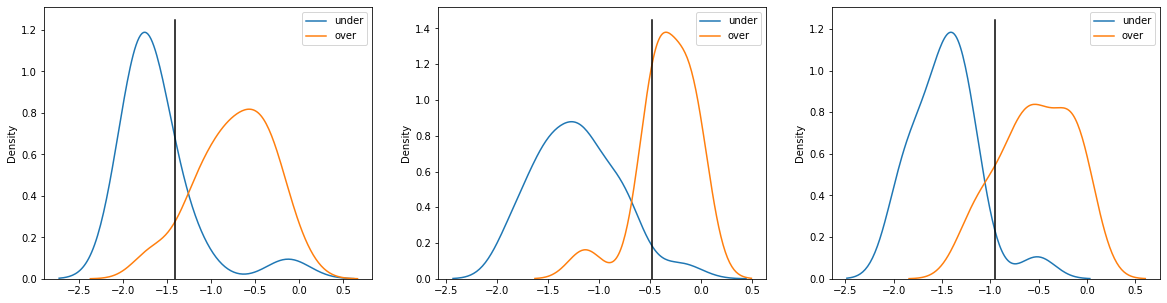

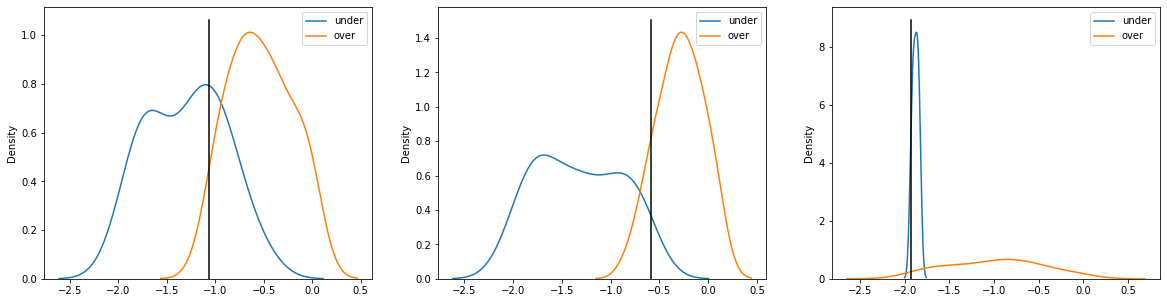

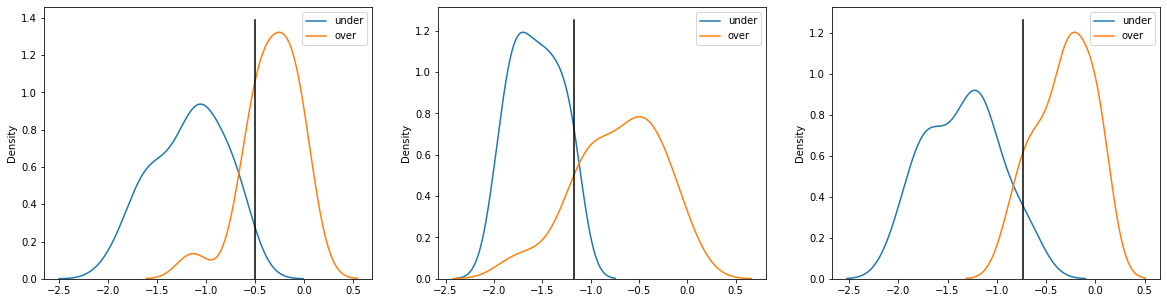

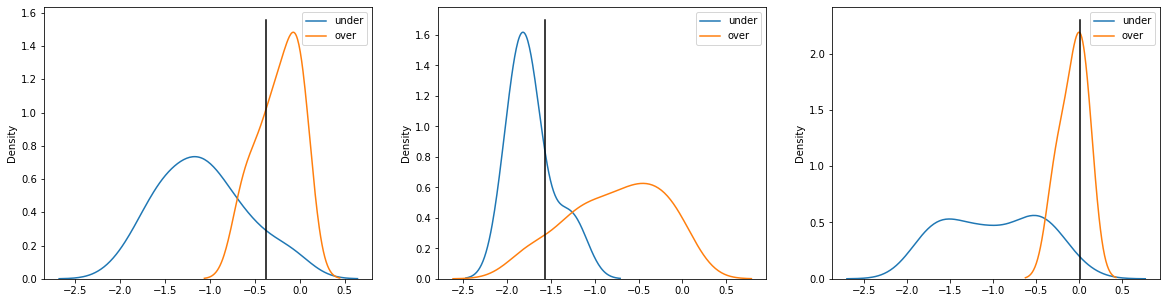

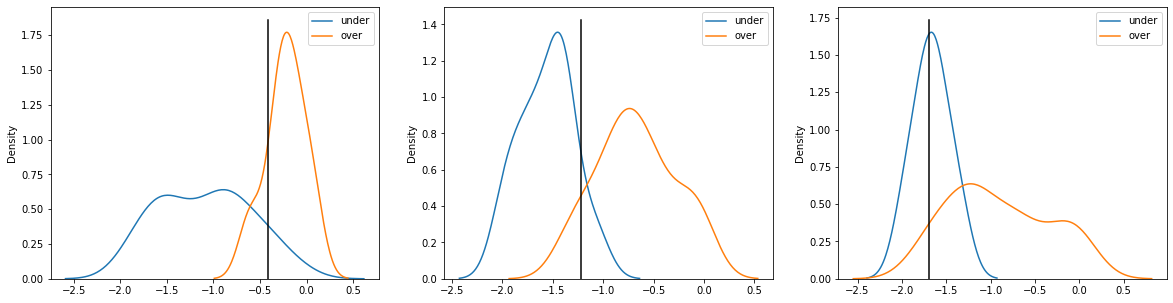

In [ ]:
if COMPUTE_OOF:
    log = np.array(log)
    for k in range(DISPLAY*3): 
        if k%3==0: plt.figure(figsize=(20,5))

        # FIND ALL EXCERPTS OVER AND UNDER
        # WITH LEFT COMPARE
        a = COMPARE*2*k
        t1 = log[a:a+COMPARE]
        p1 = pr[a:a+COMPARE,0]
        over1 = t1[p1<0.5]
        under1 = t1[p1>0.5]
    
        # FIND ALL EXCERPTS OVER AND UNDER
        # WITH RIGHT COMPARE
        a += COMPARE
        t2 = log[a:a+COMPARE]
        p2 = pr[a:a+COMPARE,0]
        over2 = t2[p2>0.5]
        under2 = t2[p2<0.5]    
        over = np.concatenate([over1,over2])
        under = np.concatenate([under1,under2])
    
        # PLOT EXCERPTS OVER AND UNDER
        plt.subplot(1,3,k%3+1)
        sns.kdeplot(under,label='under')
        sns.kdeplot(over,label='over')
        x = train.target.values[idx_v[k]]
        yy = plt.ylim()
        plt.plot([x,x],[yy[0],yy[1]],color='black')
        plt.legend()
        if k%3==2: plt.show()